<a href="https://colab.research.google.com/github/FatmaelzahraaElkhayat/Seisbench_Greece/blob/main/examples/01c_generator_pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/seisbench/seisbench/blob/additional_example_workflows/examples/01c_generator_pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://raw.githubusercontent.com/seisbench/seisbench/main/docs/_static/seisbench_logo_subtitle_outlined.svg)

*This code is necessary on colab to install SeisBench. If SeisBench is already installed on your machine, you can skip this.*

In [1]:
!pip install seisbench

# Generator pipelines

This tutorial introduces the SeisBench generator pipelines. Generator pipelines are an easy way to generate training examples for deep learning models. They can be used for simple window selection, label generation, and even data augmentation.

*Note: It is recommended to have a look at the dataset basics tutorial before following this tutorial.*

In [2]:
# A generator pipeline is a smart tool that automatically prepares training data for deep learning.
# It does things like: 1-Cutting waveforms into small windows. 2- Adding noise or normalization. 3- Creating labels for training
# Think of it like a factory that takes raw seismic data and outputs ready-to-use training samples.

# Label generation means creating answers (like P-wave or S-wave arrival times) that the model should learn to predict.
# It converts pick times from the metadata into label formats the model understands (e.g., probabilities or class labels at each time step).

# Import necessary modules from SeisBench
import seisbench.data as sbd
import seisbench.generate as sbg

## The generator object

All generation pipelines are based on SeisBench datasets. For this tutorial, we'll use the ETHZ dataset. If this dataset is not locally available, it will automatically be downloaded to your SeisBench cache. This might take a moment.

In [3]:
# Load the ETHZ dataset from SeisBench with a fixed sampling rate of 100 Hz
# If the dataset is not cached locally, it will be downloaded (~22 GB for waveforms + metadata)
# ETHZ is a global earthquake dataset, useful for general training and benchmarking

data = sbd.ETHZ(sampling_rate=100)

# Console output (not part of the code):
# WARNINGS indicate that the dataset wasn't cached locally, so SeisBench downloads it.
# Metadata (e.g., pick times, station info) and waveform data (traces) are downloaded.
# Default component order set to 'ZNE' — vertical (Z), north (N), east (E) components.

2025-06-22 13:42:05,882 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
2025-06-22 13:42:06,742 | seisbench | WARNING | Dataset ETHZ not in cache.
2025-06-22 13:42:06,744 | seisbench | WARNING | Trying to download preprocessed version from SeisBench repository.
2025-06-22 14:00:59,206 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.


The central element of the generator pipeline is the `GenericGenerator`. This generator builds upon a SeisBench dataset and is mappable, i.e., it can be indexed. Each index corresponds to one trace in the dataset.

In [11]:
# Create a GenericGenerator object which is a tool that takes a dataset and prepares it for deep learning.
# It lets us easily add things like:(Window selection, Normalization,Labels for picks, augmentation)

generator = sbg.GenericGenerator(data)

# Print the generator to inspect its current configuration.
# Output: Shows that the generator is active and currently has no augmentations added.

print(generator)

# Example Output:
# <class 'seisbench.generate.generator.GenericGenerator'> with 0 augmentations:
# 0 Augmentations means we haven’t added any steps yet —no slicing, no noise, no labels.The data is still raw and untouched.

<class 'seisbench.generate.generator.GenericGenerator'> with 0 augmentations:



By default, the generator has no augmentations. When requesting a sample, the generator will return the waveforms for this example. Let's load the first example and visualize it. Note that the return value of the generator is a dictionary. By default, the key `"X"` contains the waveforms.

Number of examples: 36743
Example: {'X': array([[  90.98797839,  105.00591444,   95.08377824, ..., -106.59047876,
        -109.21973954, -116.63044039],
       [  70.83093123,  130.64218162,   91.56002754, ...,   39.24140428,
           1.12829889,   22.43419321],
       [-138.15985177, -108.42529587, -139.39715595, ..., -116.65644067,
        -139.83376205, -116.56060547]])}


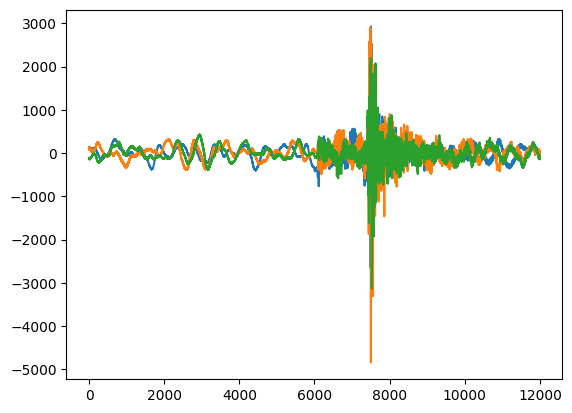

In [12]:
# Print the total number of available waveform examples in the generator
print("Number of examples:", len(generator))  # Should output something like 36743

# Access a specific sample by index (e.g., the 200th sample)
# This sample is a dictionary containing keys like 'X' (waveform data)
sample = generator[200]

# Print the raw data dictionary to inspect structure — typically shows only 'X' since no labels/augmentation added yet
print("Example:", sample)

# Import the plotting library to visualize the waveform
import matplotlib.pyplot as plt

# Plot the waveform trace:
# sample["X"] shape is (3, N), where 3 = components (Z, N, E)
# Transpose is needed to convert from (3, N) to (N, 3) so each component is plotted over time
plt.plot(sample["X"].T)  # This shows 3 colored lines for the 3 seismic components

# Output:
# A figure with time on the x-axis and amplitude on the y-axis
# All three components (Z, N, E) plotted on the same graph
# We clearly see the arrival of a seismic event around the middle of the trace

## Augmentations

Using the generator only to return the waveforms from the dataset does not add much value. However, the generator can be supplemented with augmentations. Let's first try a simple augmentation pipeline, consisting of a random window selection and a normalization.

In [13]:
# Add a RandomWindow augmentation to the generator:that cuts out a random part of the waveform (like picking a random 3-second slice from a long recording).
# It selects a random continuous segment (window) of 3000 samples from each full waveform trace. Every time we run it, we may get a different segment.
generator.augmentation(sbg.RandomWindow(windowlen=3000))  #  random window give different output each time of running

# Add a Normalize augmentation to standardize amplitude across each component: that cleans the waveform by (Removing trends (like tilts in the signal) and Making the amplitude similar in scale across all traces)
# - `detrend_axis=-1` removes any linear trend from each trace
# - `amp_norm_axis=-1` normalizes amplitude by peak value on each component (Z, N, E)
generator.augmentation(sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1))

# Print the generator again to confirm the added augmentations
print(generator)

# Output:
# Shows 2 active augmentations:
# 1. RandomWindow (selects a slice from waveform). low=None, high=None means it can pick the window from anywhere in the trace.
# 2. Normalize (detrending + amplitude normalization per component)
# Detrend (axis=-1): Removes any slow drift (linear trend) from the waveform.
# Amplitude normalization (type=peak, axis=-1): Scales each trace by its peak value, so all signals have similar height (strength).

# This generator will give us a clean, randomly selected window from each seismic trace — ready for training.

<class 'seisbench.generate.generator.GenericGenerator'> with 2 augmentations:
 1.	RandomWindow (low=None, high=None)
 2.	Normalize (Detrend (axis=-1), Amplitude normalization (type=peak, axis=-1))



Let's visualize an example. Note that we added a RandomWindow. If you rerun the code, a different window will be selected.

Example: {'X': array([[-0.04037782, -0.03685851, -0.04098078, ..., -0.26655846,
        -0.26994773, -0.25946034],
       [-0.65626304, -0.69107822, -0.64195878, ..., -0.01065509,
        -0.03390757, -0.00769028],
       [-0.59694339, -0.60754645, -0.6047224 , ...,  0.5059738 ,
         0.48542866,  0.50443977]])}


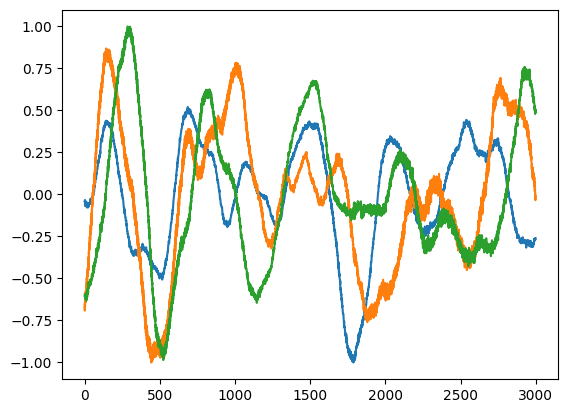

In [14]:
# Fetch a random sample (e.g., index 200) after applying the above augmentations.
# Because RandomWindow is used, every call may yield a different window.
sample = generator[200]

# Print the sample to confirm the waveform data (X). Labels are not yet included here.
print("Example:", sample)




# Plot the waveform trace after augmentation and normalization.
# The data has 3 channels: Z, N, and E. We transpose it to shape (samples, channels) for plotting.
plt.plot(sample["X"].T)

# Output: A waveform plot with amplitude ranging from -1 to 1, due to normalization.
# The randomness in windowing means this waveform snippet comes from a random part of the full trace.
# Each line = one component (Z, N, E).

A standard task in data generation is label generation. Let's generate pick labels for P picks.

In [15]:
# Add a ProbabilisticLabeller to the generator:
# This creates soft (probabilistic) labels for the "P" arrival pick.
# - label_columns: which metadata column to use for pick time ("trace_P1_arrival_sample")
# - sigma: width of the Gaussian around the pick (spread of label)
# - dim: number of label classes; here 2 means [Noise, P]

generator.augmentation(
    sbg.ProbabilisticLabeller(
        label_columns=["trace_P1_arrival_sample"],  # Use P-pick arrival (from metadata)
        sigma=50,                                   # Label spread: how wide the label curve is (bigger = smoother = wider = more tolerance)
        dim=2                                       # Label output: two label types — [Noise, P], 2-class (binary)
    )
)

# Print out the updated generator to confirm labeler has been added
print(generator)

# Output:
# Shows 3 augmentations in total — the ProbabilisticLabeller is now the last in the chain
# Note low=None, high=None: means the window can be taken from anywhere in the trace.
# Detrend (axis=-1): Removes linear trends (slopes) from the signal.
# Amplitude normalization (type=peak): Scales each waveform by its peak value so all traces have a similar strength..
# (label_type=multi_class, dim=2): Creates soft labels for P-wave picks using Gaussian curves.
# dim=2: Two classes — [Noise, P-pick]
# label_type=multi_class: Each time sample is labeled with a probability of being P or Noise

<class 'seisbench.generate.generator.GenericGenerator'> with 3 augmentations:
 1.	RandomWindow (low=None, high=None)
 2.	Normalize (Detrend (axis=-1), Amplitude normalization (type=peak, axis=-1))
 3.	ProbabilisticLabeller (label_type=multi_class, dim=2)



Let's generate samples. As we can see, samples now have two keys: "X" for the waveforms and "y" for the labels. We visualize both in the plot. Here, labels are encoded probabilistically, but Seisbench offers a range of ways for encoding labels. Check the documentation for details.

*Note: You might need to run the cell multiple times for seeing an annotation, because the P arrival might be outside the random window.*

Sample keys: dict_keys(['X', 'y'])


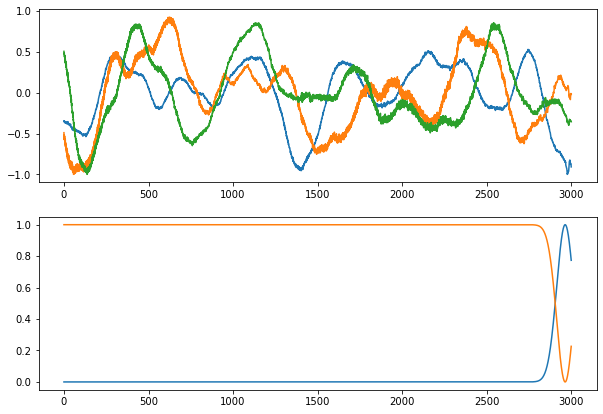

In [ ]:
# generate samples and visualize both two keys of samples: "X" for the waveforms and "y" for the labels.
# This returns a dictionary containing:
#   "X": the waveform data [3 channels(Z = vertical, N = north, E = east),  window length of 3000 samples]
#   "y": the label array [3000, 2] as The label data "y" is added using ProbabilisticLabeller with dim=2 that creates a 2-class label for each time step (First column → Noise probability and Second column → P-pick probability)
sample = generator[200]


# Print out the keys in the sample dictionary to confirm both waveform and labels exist
print("Sample keys:", sample.keys())        # Expected: dict_keys(['X', 'y'])

# Create a figure for plotting with size 10x7 inches
fig = plt.figure(figsize=(10, 7))
# Create 2 vertical subplots: axs[0] → waveform,   axs[1] → labels
axs = fig.subplots(2, 1)

# Plot the waveform
# - sample["X"] has shape (3, 3000), so we transpose it to (3000, 3) for correct time plotting
# - This will show 3 colored traces (Z, N, E components)
axs[0].plot(sample["X"].T);
axs[0].set_title("Waveform (Z, N, E)")

# Plot the label probabilities
# - sample["y"] has shape (3000, 2): first column = Noise, second = P-pick
# - Transposing gives (2, 3000), so each class is plotted as a line over time
axs[1].plot(sample["y"].T);
axs[1].set_title("Label Probabilities (Noise, P-pick)")

# Adjust spacing between subplots for better layout
# plt.tight_layout()

# Show the full plot
# plt.show()



# Output
# sample = generator[200] returns a dictionary.That dictionary has two keys ('X': the waveform array, and 'y': the label array)
# Top Plot (Waveform) shows 3 signals: vertical (Z), north (N), and east (E) components.Amplitude is normalized (as expected from Normalize), ranging from -1 to +1. The waveform is smooth and clean, showing clear motion — perfect for training.
# Bottom Plot (Labels) shows 2 lines. Blue line (Noise): close to 0 across the window — very low probability. Orange line (P-pick): a flat line at 1, means the model thinks the P-arrival is within the window
#  In this case, the P-pick location is spread smoothly due to the Gaussian function used by ProbabilisticLabeller.
# If the orange line is flat and wide, the pick falls near the center; if it's sharp and narrow, the P arrival is right at that spot.

## Branching pipelines

Sometimes, it's desirable to build a branching pipeline. For this, most augmentations in SeisBench take a key parameter. Keys can either be pairs of strings, one input and one output key, or a single string, which is used for both input and output. Implicitly, all augmentations except labels assume "X" as key, and all labels assume ("X", "y"), i.e., reading from "X" and writing to "y".

Let's build a pipeline that extracts two windows from the same trace and labels both, but only normalizes one.

In [16]:
# A branching pipeline creates two (or more) versions of the same seismic trace.
# Each version can ( have different window lengths, be processed differently, get separate labels

# Create a new pipeline using the ETHZ dataset again
generator = sbg.GenericGenerator(data)

# Extract two different windows from the same trace.
# This splits the data into two “branches”:("X1": short window (3000 samples) and "X2": longer window (8000 samples) and both come from the same original waveform "X")
# -The first window is 3000 samples long, saved in "X1"
# -The second window is 8000 samples long, saved in "X2"
generator.augmentation(sbg.RandomWindow(windowlen=3000, key=("X", "X1")))
generator.augmentation(sbg.RandomWindow(windowlen=8000, key=("X", "X2")))

# Remove the original key "X" from the data to save memory and keep only "X1" and "X2".
generator.augmentation(sbg.FilterKeys(exclude="X"))


# Normalize only the short window (X1)
# Detrend and scale amplitude per channel (axis=-1)
generator.augmentation(sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1, key="X1"))   # "X2" is not normalized — it's kept raw for comparison or contrast.


# Label "X1" (short window)to be"y1" = label for the short, cleaned signal to be stored stored in "y1", (auto from ProbabilisticLabeller)
generator.augmentation(sbg.ProbabilisticLabeller(label_columns=["trace_P1_arrival_sample"], sigma=50, dim=-2, key=("X1", "y1")))
# Label "X2" (long window) with a wider sigma = 200 to be "y2"= label for the long, unprocessed signal


generator.augmentation(sbg.ProbabilisticLabeller(label_columns=["trace_P1_arrival_sample"], sigma=200, dim=-2, key=("X2", "y2")))

# Print final structure of the generator to check the applied augmentations
print(generator)

# Output: class 'GenericGenerator'> with 6 augmentations:
#  1. RandomWindow → creates X1
#  2. RandomWindow → creates X2
#  3. FilterKeys → removes original X
#  4. Normalize → normalizes X1
#  5. ProbabilisticLabeller → creates y1 from X1
#  6. ProbabilisticLabeller → creates y2 from X2

<class 'seisbench.generate.generator.GenericGenerator'> with 6 augmentations:
 1.	RandomWindow (low=None, high=None)
 2.	RandomWindow (low=None, high=None)
 3.	Filter keys (excludes X)
 4.	Normalize (Detrend (axis=-1), Amplitude normalization (type=peak, axis=-1))
 5.	ProbabilisticLabeller (label_type=multi_class, dim=-2)
 6.	ProbabilisticLabeller (label_type=multi_class, dim=-2)



Sample keys: dict_keys(['X1', 'X2', 'y1', 'y2'])


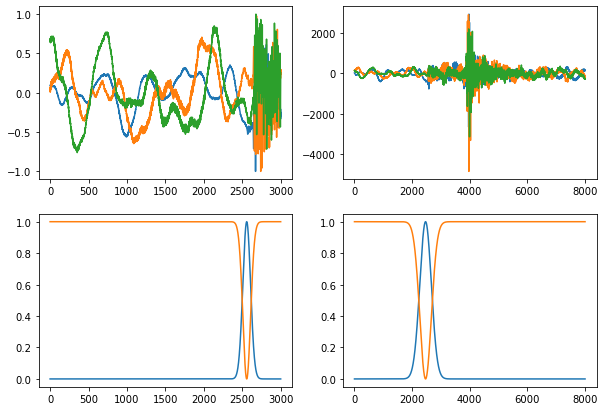

In [ ]:
sample = generator[200]
print("Sample keys:", sample.keys())

fig = plt.figure(figsize=(10, 7))
axs = fig.subplots(2, 2)
axs[0, 0].plot(sample["X1"].T);
axs[1, 0].plot(sample["y1"].T);
axs[0, 1].plot(sample["X2"].T);
axs[1, 1].plot(sample["y2"].T);

## Custom augmentations

Seisbench offers a range of built-in augmentations. However, sometime you might want to apply a custom augmentation that is not readily available. To discuss custom augmentation, we need to quickly discuss how SeisBench augmentations are built.

SeisBench augmentations are callable objects, i.e., functions or classes that implement the `__call__` method. Everytime a sample is requested, the generator first retrieves the sample from the dataset and then passes it to all augmentations one after another. For this, each augmentation gets a state dict, which it is expected to modify. Let's build a simple augmentation to inspect the state dict without modifying it. Note that we are using Python's decorator syntax here. However, using the syntax as above is also valid.

In [ ]:
generator = sbg.GenericGenerator(data)

@generator.augmentation
def print_state_dict(state_dict):
    print(state_dict)

generator[0];

{'X': (array([[-8.16016656,  2.52308443, -0.55797025, ..., -0.46353076,
         0.12343569, -1.52008214],
       [-5.65052198,  1.68766761,  1.27151696, ..., -0.63567194,
         2.78518374, -1.56848459],
       [-4.45630167,  1.01235445, -0.26532614, ...,  0.81090437,
         0.5250105 , -2.6642456 ]]), {'source_id': '2020zmwrjy', 'source_origin_time': '2020-12-27T02:46:42.620452Z', 'source_origin_uncertainty_sec': nan, 'source_latitude_deg': 47.14764063, 'source_latitude_uncertainty_km': 0.6204931895, 'source_longitude_deg': 6.37134311, 'source_longitude_uncertainty_km': 0.9277545233, 'source_depth_km': 10.965625, 'source_depth_uncertainty_km': 2.11695806, 'split': 'test', 'source_magnitude': 1.965074269, 'source_magnitude_uncertainty': 0.2128535104, 'source_magnitude_type': 'MLhc', 'source_magnitude_author': 'SED', 'path_back_azimuth_deg': 247.11081381, 'station_network_code': 'CH', 'station_code': 'MTI01', 'trace_channel': 'HG', 'station_location_code': nan, 'station_latitude_de

As we can see, the state dict maps a list of keys to tuples. Each tuple consists of a numpy array, commonly the waveforms, and a dictionary of metadata. In the beginning, the generator will populate the state dict with the waveforms and the corresponding metadata row from the dataset. It will use the key "X" for this.

When building an augmentation, it is recommended to keep the metadata consistent with the waveforms. For example, the window selection augmentations automatically modify entries like "trace_p_arrival_sample" to be consistent with the new window borders.

Now that we know of the inner structure of the state dict, let's build a simple augmentation. We'll build an augmentation that reverses the waveforms in time and writes them to a different key.

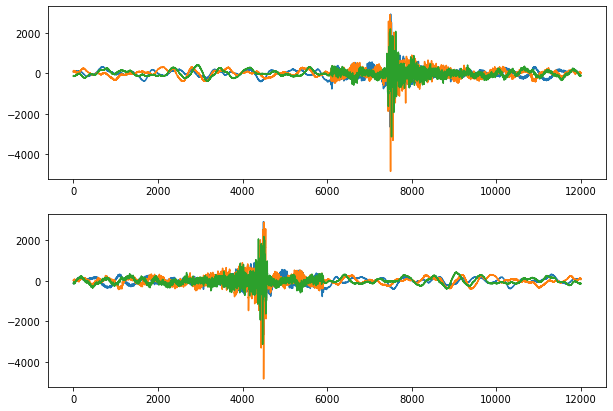

In [ ]:
generator = sbg.GenericGenerator(data)

@generator.augmentation
def reverse_waveforms(state_dict):
    waveforms, metadata = state_dict["X"]
    rev_waveforms = waveforms[:, ::-1]
    state_dict["Xr"] = (rev_waveforms, None)  # We write None to indicate that there is no valid metadata here

sample = generator[200]

fig = plt.figure(figsize=(10, 7))
axs = fig.subplots(2, 1)
axs[0].plot(sample["X"].T);
axs[1].plot(sample["Xr"].T);

Clearly, custom augmentations can be combined with built-in augmentations as necessary.

## Steered generators

So far we only looked at the `GenericGenerator`. There is another generator in SeisBench, the `SteeredGenerator`. In contrast to the `GenericGenerator`, which gets a dataset, the `SteeredGenerator` gets a dataset and a pandas dataframe with control information. This control information can for example be used to fix the windows that the generator selects for each example. This is for example useful when building evaluation pipelines.

Let's first build a dataframe with control information. Each row needs at least the `trace_name` that it describes. Here we furthermore define a window start and a window end. For simplicity, we use the same samples for each example.

In [ ]:
import pandas as pd

control = []

for i in range(200):
    row = data.metadata.iloc[i]
    control_row = {"trace_name": row["trace_name"],
                   "start_sample": 1000,
                   "end_sample": 2000}
    control.append(control_row)

control = pd.DataFrame(control)
control

,trace_name,start_sample,end_sample
0,"bucket1$0,:3,:30001",1000,2000
1,"bucket31$0,:3,:14401",1000,2000
2,"bucket1$1,:3,:30001",1000,2000
3,"bucket0$0,:3,:24001",1000,2000
4,"bucket1$2,:3,:30001",1000,2000
...,...,...,...
195,"bucket0$126,:3,:24001",1000,2000
196,"bucket0$127,:3,:24001",1000,2000
197,"bucket0$128,:3,:24001",1000,2000
198,"bucket0$129,:3,:24001",1000,2000


Now let's create the `SteeredGenerator` using the control frame. We'll only give it one augmentation, the `SteeredWindow`, which selects the window given in the control frame. Note however, that just as for the `GenericGenerator`, all augmentations can be used and combined.

In [ ]:
generator = sbg.SteeredGenerator(data, control)
generator.augmentation(sbg.SteeredWindow(windowlen=1000))

print(generator)

SteeredGenerator with 1 augmentations:
 1.	SteeredWindow



Let's now load a sample. As before, we get the sample. Note however, that if you rerun the cell, the sample will stay unchanged, as the steered window always selects the same window as described in the control information.

{'X': array([[ 2.44763588, -1.20235043,  0.86175249, ..., -2.97880178,
         0.98846858, -1.00258536],
       [ 2.47068701, -0.30520958, -0.22972751, ..., -2.04153181,
         1.56905241, -0.66467658],
       [ 3.47353212,  0.00594969,  0.81882761, ..., -1.11923654,
        -0.89663023,  1.11988248]]), 'window_borders': array([   0, 1000])}


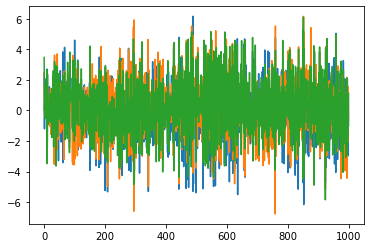

In [ ]:
sample = generator[0]
print(sample)

plt.plot(sample["X"].T)

## Outlook

Now you learned the basics of SeisBench generator pipelines. However, we left out one important piece so far: the `GenericGenerator` is a pytorch dataset. This means, that you can directly pass it to a pytorch data loader, which will automatically handle parallel processing and batching. If you want to see an example for this, check the notebook on training a model.